In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import glob
import time
import pytz
import datetime as dt
import dateutil
from itertools import chain
from cycler import cycler
from io import StringIO


import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pvlib as pvlib
import seaborn as sns


ONE_DAY = dt.timedelta(days=1)

In [4]:
# Style of figures
plt.style.use('seaborn-poster')
plt.rcParams['figure.figsize'] = 15, 6.5
# get colormap
#cmap=plt.cm.hsv
cmap =  plt.cm.gist_ncar
#cmap=plt.cm.brg
# build cycler with 10 equally spaced colors from that colormap
c = cycler('color', cmap(np.linspace(0,1,17)) )
# supply cycler to the rcParam
plt.rcParams["axes.prop_cycle"] = c

In [5]:
#function to find all files 
def find_files(date_1, date_2, mask, bdd_dir):

    tmp_date = date_1
    list_files = []
    while tmp_date <= date_2:
        
        in_dir = bdd_dir.format(tmp_date)
        tmp_file = mask.format(tmp_date)
        tmp_file = os.path.join(in_dir, tmp_file)
        #print(tmp_file)
        tmp_list = sorted(glob.glob(tmp_file))
        #print(tmp_list)
    
        if len(tmp_list) != 0:
            list_files.append(tmp_list)
        
        tmp_date += ONE_DAY
    
    return sorted([file_ for file_ in chain.from_iterable(list_files)])




In [ ]:
## PV Modules DrahiX 

## Tilt = 30º, Orientation = 2ºW

    # 46,48,49,51 LONGI LR6-60PE-310M(reflector plane in face)
    # 45,47,50,52 LONGI LR6-60HPH-320M (reflector plane in face)

    # 42,43 LONGI LR6-60PE-310M
    # 41,44 LONGI LR6-60HPH-320M

## Tilt = 20º, Orientation = 2ºW

    # 33-40 LONGI_LR6-60BP_305W
    # 26,28,29,32 LONGI LR6-60HPH-320M 
    # 25,27,29,31 LONGI LR6-60PE-310M
    # 17-24  QCELLS Q.PEAK DUO-G6 345
    #  9-16  VMH 300-6-60-MW (white)
    #  1- 8  VMH 300-6-60-MB (black)





In [6]:
Wp = [300]*8 + [300]*8 + [345]*8 + [310,320]*4 + \
     [305]*8 + [320,310,310,320] + \
     [320,310]*2 + [310,320]*2

S = [1.633]*16 + [1.74*1.03]*8 + [1.65*0.991,1.683*0.996]*4 + \
    [1.664*0.996]*8 + [1.683*0.996,1.65*0.991,1.65*0.991,1.683*0.996] + \
    [1.683*0.996,1.65*0.991]*2 + [1.65*0.991,1.683*0.996]*2

# Creating a list of file names

In [7]:
folder=''
#filename='Real_Time_Saving_{:%Y-%m-%d}*.txt'
filename='PV_DrahiX_modules_Meteo_SIRTA_20200801_20211231.csv'
#filename='/Users/jbadosa/Downloads/Drahi*.csv'


files=glob.glob(filename)
print(files)




['PV_DrahiX_modules_Meteo_SIRTA_20200801_20211231.csv']


# Read the Data

In [9]:
data = []
data = pd.read_csv(
    filename, # nom du fichier
    sep=',',  # le caractère utilisé comme séparateur de colonne
    header=0,  # la ligne contenant le titre des colonnes
    infer_datetime_format=True,  # on le laisse tenter de décoder les dates seules
    parse_dates=['datetime'],  # on indique les colonnes contenant des dates
    index_col=['datetime'],  # la colonne jouant le role "d'index", la colonne principale
)

In [10]:
data.tail(4)

,AirTemp,Diffuse_Solar_Flux,Direct_Solar_Flux,Downwelling_IR_Flux,GHI_TOA,GHI_clear,Global_Solar_Flux,P01,P02,P03,...,SAA,SZA,Tp,Tp_sandia,doy,pres,rain,rh,wd,ws
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-02 21:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,9.334,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-02 21:15:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,9.334,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-02 21:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,9.048,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-02 21:45:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,9.191,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
data.columns

Index(['AirTemp', 'Diffuse_Solar_Flux', 'Direct_Solar_Flux',
       'Downwelling_IR_Flux', 'GHI_TOA', 'GHI_clear', 'Global_Solar_Flux',
       'P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10',
       'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20',
       'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30',
       'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'P38', 'P39', 'P40',
       'P41', 'P42', 'P43', 'P44', 'P45', 'P46', 'P47', 'P48', 'P49', 'P50',
       'P51', 'P52', 'P53', 'PAC', 'PDC', 'POA', 'POAc20', 'POAc30', 'SAA',
       'SZA', 'Tp', 'Tp_sandia', 'doy', 'pres', 'rain', 'rh', 'wd', 'ws'],
      dtype='object')

In [12]:
Clean_data = data[["Diffuse_Solar_Flux", "Direct_Solar_Flux",
                   "Global_Solar_Flux",
                   "SAA","SZA", "POA", "AirTemp", "ws","Tp",
                   'P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10',
       'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20',
       'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30',
       'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'P38', 'P39', 'P40',
       'P41', 'P42', 'P43', 'P44', 'P45', 'P46', 'P47', 'P48', 'P49', 'P50',
       'P51', 'P52',]]
Clean_data

,Diffuse_Solar_Flux,Direct_Solar_Flux,Global_Solar_Flux,SAA,SZA,POA,AirTemp,ws,Tp,P01,...,P43,P44,P45,P46,P47,P48,P49,P50,P51,P52
datetime,,,,,,,,,,,,,,,,,,,,,
2020-08-01 00:00:00+00:00,-1.077,-0.377,-0.875,-177.411,90.0,13.040,23.492,2.298,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-01 00:15:00+00:00,-1.173,-0.450,-0.928,-173.536,90.0,7.705,23.027,2.226,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-01 00:30:00+00:00,-1.173,-0.471,-0.917,-169.682,90.0,6.943,22.518,2.416,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-01 00:45:00+00:00,-1.170,-0.428,-0.978,-165.862,90.0,9.992,22.145,2.792,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-01 01:00:00+00:00,-1.173,-0.419,-1.001,-162.088,90.0,6.181,21.883,2.694,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-02 20:45:00+00:00,NaN,NaN,NaN,NaN,NaN,6.181,NaN,NaN,9.334,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-02 21:00:00+00:00,NaN,NaN,NaN,NaN,NaN,6.181,NaN,NaN,9.334,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-02 21:15:00+00:00,NaN,NaN,NaN,NaN,NaN,6.181,NaN,NaN,9.334,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
Clean_data.replace([np.inf, -np.inf], np.nan, inplace=True)
Clean_data.dropna(inplace=True)
Clean_data

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-13-14801a9d8d69>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean_data.dropna(inplace=True)


,Diffuse_Solar_Flux,Direct_Solar_Flux,Global_Solar_Flux,SAA,SZA,POA,AirTemp,ws,Tp,P01,...,P43,P44,P45,P46,P47,P48,P49,P50,P51,P52
datetime,,,,,,,,,,,,,,,,,,,,,
2020-09-10 16:15:00+00:00,115.557,616.806,299.701,76.671,72.576,326.266,25.117,1.489,30.392,63.618,...,94.552,103.974,106.367,99.085,102.576,104.296,32.948,39.747,102.291,106.469
2020-09-10 16:30:00+00:00,80.555,554.803,223.628,79.636,75.001,229.478,24.845,2.261,30.105,37.748,...,66.347,76.132,69.968,68.382,72.388,75.474,21.428,24.670,65.382,78.326
2020-09-10 17:15:00+00:00,37.224,329.035,81.668,88.253,82.386,62.577,24.268,1.915,23.372,12.696,...,23.600,21.284,13.097,18.356,16.813,22.213,8.648,10.020,11.412,10.488
2020-09-10 17:30:00+00:00,26.669,214.327,45.824,91.071,84.863,25.996,24.043,1.799,21.367,6.541,...,7.827,5.092,4.490,4.532,5.830,7.249,6.435,6.383,7.556,5.758
2020-09-11 06:00:00+00:00,45.545,204.438,70.595,-89.165,83.453,45.048,15.522,1.427,11.626,15.284,...,11.747,10.426,9.751,10.436,11.037,9.609,10.805,12.138,10.760,11.653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 14:15:00+00:00,56.442,573.277,167.197,34.388,79.035,335.411,14.259,3.084,22.799,59.701,...,127.711,79.201,73.345,19.622,74.190,21.998,33.059,79.384,23.009,73.933
2021-12-31 14:30:00+00:00,72.811,327.503,129.575,37.567,80.487,195.184,14.295,2.421,21.224,44.089,...,87.016,60.152,48.205,25.503,42.576,33.534,28.178,55.179,28.381,75.443
2021-12-31 14:45:00+00:00,60.465,0.186,60.427,40.680,82.047,61.053,14.051,2.467,16.353,17.617,...,16.294,16.271,15.866,16.899,16.916,17.248,17.987,17.263,18.686,17.759


# Modelling Power using best POA and Temp Models for P05(Mono-Si Black)

In [14]:
#Modelling POA for P05
air_mass = pvlib.atmosphere.get_relative_airmass(Clean_data.SZA, model='kasten1966')
tilt=20
ori = 2
doy = Clean_data.index.dayofyear

Clean_data['GHI_TOA']=(pvlib.irradiance.get_extra_radiation(datetime_or_doy=doy)*np.cos(Clean_data.SZA))

total_irrads=pvlib.irradiance.get_total_irradiance(surface_tilt=tilt,surface_azimuth=ori,
                                         solar_zenith=Clean_data.SZA,solar_azimuth=Clean_data.SAA,
                                         dni=Clean_data.Direct_Solar_Flux,
                                         ghi=Clean_data.Global_Solar_Flux,
                                         dhi=Clean_data.Diffuse_Solar_Flux,
                                         dni_extra=Clean_data.GHI_TOA,
                                         airmass=air_mass,
                                         albedo=.20,
                                         model='isotropic')
Clean_data['Sky_Diffuse_Isotropic_POA_P05']=total_irrads.poa_global
Clean_data.Sky_Diffuse_Isotropic_POA_P05

<ipython-input-14-655ce3a3fbc6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean_data['GHI_TOA']=(pvlib.irradiance.get_extra_radiation(datetime_or_doy=doy)*np.cos(Clean_data.SZA))
<ipython-input-14-655ce3a3fbc6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean_data['Sky_Diffuse_Isotropic_POA_P05']=total_irrads.poa_global


datetime
2020-09-10 16:15:00+00:00    340.648730
2020-09-10 16:30:00+00:00    253.645781
2020-09-10 17:15:00+00:00     84.851072
2020-09-10 17:30:00+00:00     45.357905
2020-09-11 06:00:00+00:00     65.088941
                                ...    
2021-12-31 14:15:00+00:00    320.763499
2021-12-31 14:30:00+00:00    212.121623
2021-12-31 14:45:00+00:00     59.079544
2021-12-31 15:00:00+00:00     51.771009
2021-12-31 15:30:00+00:00     22.771628
Name: Sky_Diffuse_Isotropic_POA_P05, Length: 14468, dtype: float64

In [15]:
#Temp Modelling for P05
Clean_data['SAPM_Temp_Model_P05']=pvlib.temperature.sapm_module(poa_global=Clean_data.Sky_Diffuse_Isotropic_POA_P05, 
                                                                temp_air=Clean_data.AirTemp,
                                                                wind_speed=Clean_data.ws, a=-3.56, b=-0.075)
Clean_data.SAPM_Temp_Model_P05

<ipython-input-15-8cbd1dfe163f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean_data['SAPM_Temp_Model_P05']=pvlib.temperature.sapm_module(poa_global=Clean_data.Sky_Diffuse_Isotropic_POA_P05,


datetime
2020-09-10 16:15:00+00:00    33.781003
2020-09-10 16:30:00+00:00    30.933269
2020-09-10 17:15:00+00:00    26.358227
2020-09-10 17:30:00+00:00    25.170113
2020-09-11 06:00:00+00:00    17.185177
                               ...    
2021-12-31 14:15:00+00:00    21.497428
2021-12-31 14:30:00+00:00    19.325829
2021-12-31 14:45:00+00:00    15.447347
2021-12-31 15:00:00+00:00    14.946213
2021-12-31 15:30:00+00:00    13.946039
Name: SAPM_Temp_Model_P05, Length: 14468, dtype: float64

In [16]:
Clean_data['Power_Model_P05'] = pvlib.pvsystem.pvwatts_dc(g_poa_effective=Clean_data.Sky_Diffuse_Isotropic_POA_P05,
                                                          temp_cell=Clean_data.SAPM_Temp_Model_P05,
                                                          pdc0=300,
                                                          gamma_pdc=-0.0037,
                                                          temp_ref=25.0)
Clean_data.Power_Model_P05

<ipython-input-16-18e9e1be8b5e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean_data['Power_Model_P05'] = pvlib.pvsystem.pvwatts_dc(g_poa_effective=Clean_data.Sky_Diffuse_Isotropic_POA_P05,


datetime
2020-09-10 16:15:00+00:00    98.874345
2020-09-10 16:30:00+00:00    74.423241
2020-09-10 17:15:00+00:00    25.327398
2020-09-10 17:30:00+00:00    13.598807
2020-09-11 06:00:00+00:00    20.091293
                               ...    
2021-12-31 14:15:00+00:00    97.476132
2021-12-31 14:30:00+00:00    64.972499
2021-12-31 14:45:00+00:00    18.350310
2021-12-31 15:00:00+00:00    16.109052
2021-12-31 15:30:00+00:00     7.110894
Name: Power_Model_P05, Length: 14468, dtype: float64

In [17]:
Clean_data.replace([np.inf, -np.inf], np.nan, inplace=True)
Clean_data.dropna(inplace=True)
Clean_data.Power_Model_P05

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-17-3e59d4e8f270>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean_data.dropna(inplace=True)


datetime
2020-09-10 16:15:00+00:00    98.874345
2020-09-10 16:30:00+00:00    74.423241
2020-09-10 17:15:00+00:00    25.327398
2020-09-10 17:30:00+00:00    13.598807
2020-09-11 06:00:00+00:00    20.091293
                               ...    
2021-12-31 14:15:00+00:00    97.476132
2021-12-31 14:30:00+00:00    64.972499
2021-12-31 14:45:00+00:00    18.350310
2021-12-31 15:00:00+00:00    16.109052
2021-12-31 15:30:00+00:00     7.110894
Name: Power_Model_P05, Length: 14468, dtype: float64

In [18]:
Clean_data.columns

Index(['Diffuse_Solar_Flux', 'Direct_Solar_Flux', 'Global_Solar_Flux', 'SAA',
       'SZA', 'POA', 'AirTemp', 'ws', 'Tp', 'P01', 'P02', 'P03', 'P04', 'P05',
       'P06', 'P07', 'P08', 'P09', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15',
       'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25',
       'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35',
       'P36', 'P37', 'P38', 'P39', 'P40', 'P41', 'P42', 'P43', 'P44', 'P45',
       'P46', 'P47', 'P48', 'P49', 'P50', 'P51', 'P52', 'GHI_TOA',
       'Sky_Diffuse_Isotropic_POA_P05', 'SAPM_Temp_Model_P05',
       'Power_Model_P05'],
      dtype='object')

# Machine learning Linear regression model


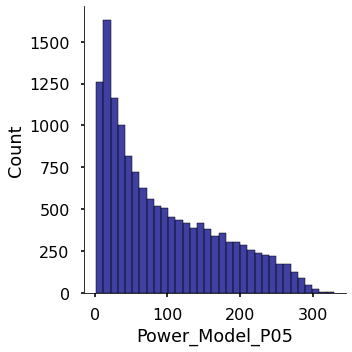

In [20]:
sns.displot(Clean_data['Power_Model_P05'])

In [63]:
Clean_data1X = Clean_data[['POA','Tp']]
Clean_data1X
Clean_data1Y = Clean_data[['P05']]
Clean_data1Y

,P05
datetime,
2020-09-10 16:15:00+00:00,103.269
2020-09-10 16:30:00+00:00,71.166
2020-09-10 17:15:00+00:00,15.941
2020-09-10 17:30:00+00:00,6.333
2020-09-11 06:00:00+00:00,14.131
...,...
2021-12-31 14:15:00+00:00,20.243
2021-12-31 14:30:00+00:00,25.481
2021-12-31 14:45:00+00:00,16.070


In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Clean_data1X, Clean_data1Y, test_size=0.4, random_state=101)

In [65]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

In [66]:
lm.fit(X_train,y_train)

LinearRegression()

In [67]:
 print(lm.intercept_)

[-1.13433093]


In [68]:
print(lm.coef_)

[[0.25333708 0.48255122]]


In [69]:
predictions = lm.predict(X_test)

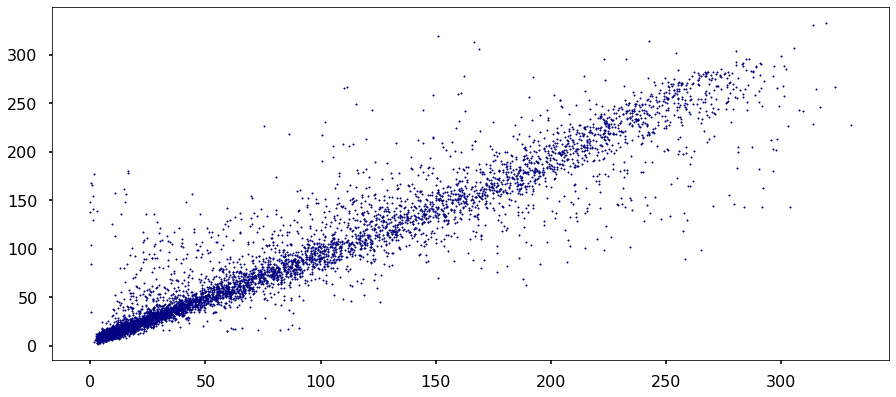

In [72]:
plt.scatter(y_test,predictions,s=2)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

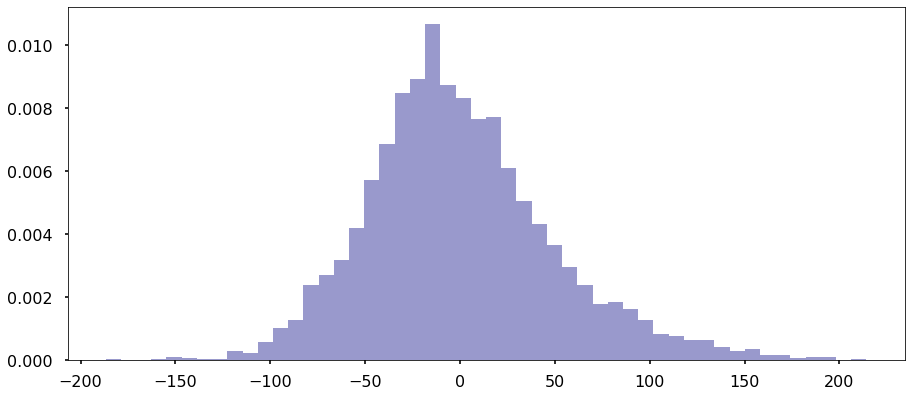

In [61]:
sns.distplot((y_test - predictions))

In [74]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
np.sqrt(mean_squared_error(y_test, predictions))

24.6680586180494

<AxesSubplot:xlabel='datetime'>

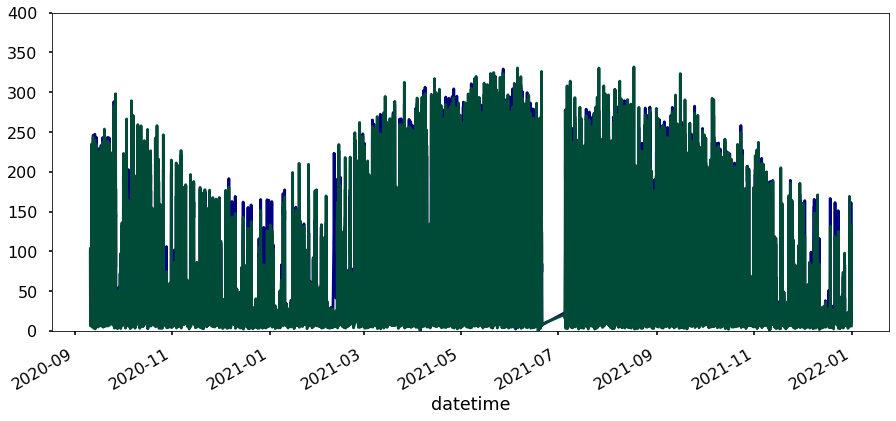

In [50]:
Clean_data.Power_Model_P05.plot()
plt.ylim(0,400)
Clean_data.loc[:]['P05'].plot()

12.65333647194141

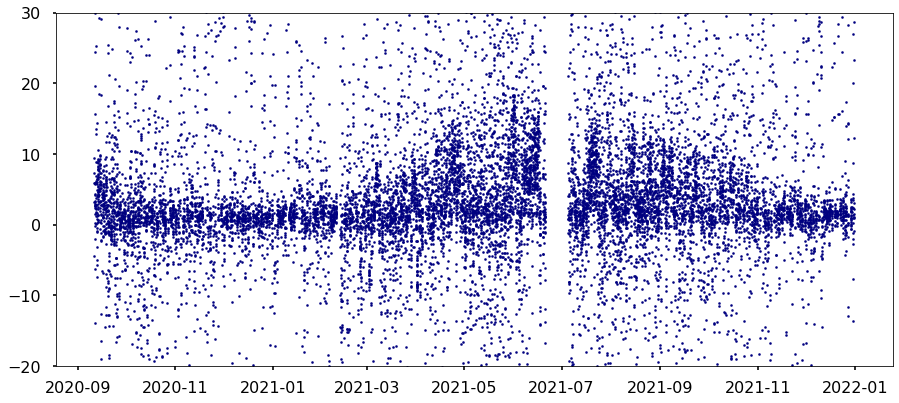

In [51]:
plt.scatter(Clean_data.loc[:]['P05'].index, Clean_data.Power_Model_P05 - Clean_data.loc[:]['P05'], s=4)
plt.ylim(-20,30)
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_absolute_error(Clean_data.Power_Model_P05, Clean_data.P05)

# Modelling Power for P13(Mono-Si White) using Temp and POA models

In [ ]:
#Modelling POA for P13
air_mass = pvlib.atmosphere.get_relative_airmass(Clean_data.SZA, model='kasten1966')
tilt=20
ori = 2
doy = Clean_data.index.dayofyear

Clean_data['GHI_TOA']=(pvlib.irradiance.get_extra_radiation(datetime_or_doy=doy)*np.cos(Clean_data.SZA))

total_irrads=pvlib.irradiance.get_total_irradiance(surface_tilt=tilt,surface_azimuth=ori,
                                         solar_zenith=Clean_data.SZA,solar_azimuth=Clean_data.SAA,
                                         dni=Clean_data.Direct_Solar_Flux,
                                         ghi=Clean_data.Global_Solar_Flux,
                                         dhi=Clean_data.Diffuse_Solar_Flux,
                                         dni_extra=Clean_data.GHI_TOA,
                                         airmass=air_mass,
                                         albedo=.20,
                                         model='isotropic')
Clean_data['Sky_Diffuse_Isotropic_POA_P13']=total_irrads.poa_global
Clean_data.Sky_Diffuse_Isotropic_POA_P13

In [ ]:
#Temp Modelling for P13
Clean_data['SAPM_Temp_Model_P13']=pvlib.temperature.sapm_module(poa_global=Clean_data.Sky_Diffuse_Isotropic_POA_P13, 
                                                                temp_air=Clean_data.AirTemp,
                                                                wind_speed=Clean_data.ws, a=-3.56, b=-0.075)
Clean_data.SAPM_Temp_Model_P13

In [ ]:
Clean_data['Power_Model_P13'] = pvlib.pvsystem.pvwatts_dc(g_poa_effective=Clean_data.Sky_Diffuse_Isotropic_POA_P13,
                                                          temp_cell=Clean_data.SAPM_Temp_Model_P13,
                                                          pdc0=300,
                                                          gamma_pdc=-0.0037,
                                                          temp_ref=25.0)
Clean_data.Power_Model_P13

In [ ]:
Clean_data.replace([np.inf, -np.inf], np.nan, inplace=True)
Clean_data.dropna(inplace=True)
Clean_data.Power_Model_P13

In [ ]:
Clean_data.Power_Model_P13.plot()
plt.ylim(0,400)
Clean_data.loc[:]['P13'].plot()

In [ ]:
plt.scatter(Clean_data.loc[:]['P13'].index, Clean_data.Power_Model_P13 - Clean_data.loc[:]['P13'], s=4)
plt.ylim(-20,30)
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_absolute_error(Clean_data.Power_Model_P13, Clean_data.P13)

In [ ]:
data['Power_Model_P13'] = pvlib.pvsystem.pvwatts_dc(data.POAc20, temp_cell= Sandia_Temp_Model, pdc0 = 300, gamma_pdc= -0.0037, temp_ref=25.0)
data.Power_Model_P13

In [ ]:
data.Power_Model_P13.plot()
plt.ylim(0,400)
data.loc[:]['P13'].plot()

In [ ]:
plt.scatter(data.loc[:]['P13'].index, data.Power_Model_P13 - data.loc[:]['P13'], s=4)
plt.ylim(-20,30)
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_absolute_error(data.Power_Model_P13, data.P13)

# Modelling Power for P21(Q-Half Cells) using Temp and POA models

In [ ]:
#Modelling POA for P21
air_mass = pvlib.atmosphere.get_relative_airmass(Clean_data.SZA, model='kasten1966')
tilt=20
ori = 2
doy = Clean_data.index.dayofyear

Clean_data['GHI_TOA']=(pvlib.irradiance.get_extra_radiation(datetime_or_doy=doy)*np.cos(Clean_data.SZA))

total_irrads=pvlib.irradiance.get_total_irradiance(surface_tilt=tilt,surface_azimuth=ori,
                                         solar_zenith=Clean_data.SZA,solar_azimuth=Clean_data.SAA,
                                         dni=Clean_data.Direct_Solar_Flux,
                                         ghi=Clean_data.Global_Solar_Flux,
                                         dhi=Clean_data.Diffuse_Solar_Flux,
                                         dni_extra=Clean_data.GHI_TOA,
                                         airmass=air_mass,
                                         albedo=.20,
                                         model='isotropic')
Clean_data['Sky_Diffuse_Isotropic_POA_P21']=total_irrads.poa_global
Clean_data.Sky_Diffuse_Isotropic_POA_P21

In [ ]:
#Temp Modelling for P21
Clean_data['SAPM_Temp_Model_P21']=pvlib.temperature.sapm_module(poa_global=Clean_data.Sky_Diffuse_Isotropic_POA_P21, 
                                                                temp_air=Clean_data.AirTemp,
                                                                wind_speed=Clean_data.ws, a=-3.56, b=-0.075)
Clean_data.SAPM_Temp_Model_P21

In [ ]:
Clean_data['Power_Model_P21'] = pvlib.pvsystem.pvwatts_dc(g_poa_effective=Clean_data.Sky_Diffuse_Isotropic_POA_P21,
                                                          temp_cell=Clean_data.SAPM_Temp_Model_P21,
                                                          pdc0=345,
                                                          gamma_pdc=-0.0037,
                                                          temp_ref=25.0)
Clean_data.Power_Model_P21

In [ ]:
Clean_data.replace([np.inf, -np.inf], np.nan, inplace=True)
Clean_data.dropna(inplace=True)
Clean_data.Power_Model_P21

In [ ]:
Clean_data.Power_Model_P21.plot()
plt.ylim(0,400)
Clean_data.loc[:]['P21'].plot()

In [ ]:
plt.scatter(Clean_data.loc[:]['P21'].index, Clean_data.Power_Model_P21 - Clean_data.loc[:]['P21'], s=4)
plt.ylim(-20,30)
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_absolute_error(Clean_data.Power_Model_P21, Clean_data.P21)

In [ ]:
data['Power_Model_P21'] = pvlib.pvsystem.pvwatts_dc(data.POAc20, temp_cell= Sandia_Temp_Model, pdc0 = 345, gamma_pdc= -0.0037, temp_ref=25.0)
data.Power_Model_P21

In [ ]:
data.Power_Model_P21.plot()
plt.ylim(0,400)
data.loc[:]['P21'].plot()

In [ ]:
plt.scatter(data.loc[:]['P21'].index, data.Power_Model_P21 - data.loc[:]['P21'], s=4)
plt.ylim(-20,30)
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_absolute_error(data.Power_Model_P21, data.P21)

# Modelling Power for P28(MONO PERC Half Cells) using Temp and POA models

In [ ]:
#Modelling POA for P28
air_mass = pvlib.atmosphere.get_relative_airmass(Clean_data.SZA, model='kasten1966')
tilt=20
ori = 2
doy = Clean_data.index.dayofyear

Clean_data['GHI_TOA']=(pvlib.irradiance.get_extra_radiation(datetime_or_doy=doy)*np.cos(Clean_data.SZA))

total_irrads=pvlib.irradiance.get_total_irradiance(surface_tilt=tilt,surface_azimuth=ori,
                                         solar_zenith=Clean_data.SZA,solar_azimuth=Clean_data.SAA,
                                         dni=Clean_data.Direct_Solar_Flux,
                                         ghi=Clean_data.Global_Solar_Flux,
                                         dhi=Clean_data.Diffuse_Solar_Flux,
                                         dni_extra=Clean_data.GHI_TOA,
                                         airmass=air_mass,
                                         albedo=.20,
                                         model='isotropic')
Clean_data['Sky_Diffuse_Isotropic_POA_P28']=total_irrads.poa_global
Clean_data.Sky_Diffuse_Isotropic_POA_P28

In [ ]:
#Temp Modelling for P28
Clean_data['SAPM_Temp_Model_P28']=pvlib.temperature.sapm_module(poa_global=Clean_data.Sky_Diffuse_Isotropic_POA_P28, 
                                                                temp_air=Clean_data.AirTemp,
                                                                wind_speed=Clean_data.ws, a=-3.56, b=-0.075)
Clean_data.SAPM_Temp_Model_P28

In [ ]:
Clean_data['Power_Model_P28'] = pvlib.pvsystem.pvwatts_dc(g_poa_effective=Clean_data.Sky_Diffuse_Isotropic_POA_P28,
                                                          temp_cell=Clean_data.SAPM_Temp_Model_P28,
                                                          pdc0=320,
                                                          gamma_pdc=-0.0037,
                                                          temp_ref=25.0)
Clean_data.Power_Model_P28

In [ ]:
Clean_data.replace([np.inf, -np.inf], np.nan, inplace=True)
Clean_data.dropna(inplace=True)
Clean_data.Power_Model_P28

In [ ]:
Clean_data.Power_Model_P28.plot()
plt.ylim(0,400)
Clean_data.loc[:]['P28'].plot()

In [ ]:
plt.scatter(Clean_data.loc[:]['P28'].index, Clean_data.Power_Model_P28 - Clean_data.loc[:]['P28'], s=4)
plt.ylim(-20,30)
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_absolute_error(Clean_data.Power_Model_P28, Clean_data.P28)

In [ ]:
data['Power_Model_P28'] = pvlib.pvsystem.pvwatts_dc(data.POAc20, temp_cell= Sandia_Temp_Model, pdc0 = 320, gamma_pdc= -0.0037, temp_ref=25.0)
data.Power_Model_P28

In [ ]:
data.Power_Model_P28.plot()
plt.ylim(0,400)
data.loc[:]['P28'].plot()

In [ ]:
plt.scatter(data.loc[:]['P28'].index, data.Power_Model_P28 - data.loc[:]['P28'], s=4)
plt.ylim(-20,30)
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_absolute_error(data.Power_Model_P28, data.P28)

# Modelling the Power of P29(MONO PERC) using temp and POA models

In [ ]:
#Modelling POA for P29
air_mass = pvlib.atmosphere.get_relative_airmass(Clean_data.SZA, model='kasten1966')
tilt=20
ori = 2
doy = Clean_data.index.dayofyear

Clean_data['GHI_TOA']=(pvlib.irradiance.get_extra_radiation(datetime_or_doy=doy)*np.cos(Clean_data.SZA))

total_irrads=pvlib.irradiance.get_total_irradiance(surface_tilt=tilt,surface_azimuth=ori,
                                         solar_zenith=Clean_data.SZA,solar_azimuth=Clean_data.SAA,
                                         dni=Clean_data.Direct_Solar_Flux,
                                         ghi=Clean_data.Global_Solar_Flux,
                                         dhi=Clean_data.Diffuse_Solar_Flux,
                                         dni_extra=Clean_data.GHI_TOA,
                                         airmass=air_mass,
                                         albedo=.20,
                                         model='isotropic')
Clean_data['Sky_Diffuse_Isotropic_POA_P29']=total_irrads.poa_global
Clean_data.Sky_Diffuse_Isotropic_POA_P29

In [ ]:
#Temp Modelling for P29
Clean_data['SAPM_Temp_Model_P29']=pvlib.temperature.sapm_module(poa_global=Clean_data.Sky_Diffuse_Isotropic_POA_P29, 
                                                                temp_air=Clean_data.AirTemp,
                                                                wind_speed=Clean_data.ws, a=-3.56, b=-0.075)
Clean_data.SAPM_Temp_Model_P29

In [ ]:
Clean_data['Power_Model_P29'] = pvlib.pvsystem.pvwatts_dc(g_poa_effective=Clean_data.Sky_Diffuse_Isotropic_POA_P29,
                                                          temp_cell=Clean_data.SAPM_Temp_Model_P29,
                                                          pdc0=310,
                                                          gamma_pdc=-0.0037,
                                                          temp_ref=25.0)
Clean_data.Power_Model_P29

In [ ]:
Clean_data.replace([np.inf, -np.inf], np.nan, inplace=True)
Clean_data.dropna(inplace=True)
Clean_data.Power_Model_P29

In [ ]:
Clean_data.Power_Model_P29.plot()
plt.ylim(0,400)
Clean_data.loc[:]['P29'].plot()

In [ ]:
plt.scatter(Clean_data.loc[:]['P29'].index, Clean_data.Power_Model_P29 - Clean_data.loc[:]['P29'], s=4)
plt.ylim(-20,30)
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_absolute_error(Clean_data.Power_Model_P29, Clean_data.P29)

# Modelling the Power of P37 to find the effect of Bificial PERC

In [ ]:
#Modelling POA for P37
air_mass = pvlib.atmosphere.get_relative_airmass(Clean_data.SZA, model='kasten1966')
tilt=20
ori = 2
doy = Clean_data.index.dayofyear

Clean_data['GHI_TOA']=(pvlib.irradiance.get_extra_radiation(datetime_or_doy=doy)*np.cos(Clean_data.SZA))

total_irrads=pvlib.irradiance.get_total_irradiance(surface_tilt=tilt,surface_azimuth=ori,
                                         solar_zenith=Clean_data.SZA,solar_azimuth=Clean_data.SAA,
                                         dni=Clean_data.Direct_Solar_Flux,
                                         ghi=Clean_data.Global_Solar_Flux,
                                         dhi=Clean_data.Diffuse_Solar_Flux,
                                         dni_extra=Clean_data.GHI_TOA,
                                         airmass=air_mass,
                                         albedo=.20,
                                         model='isotropic')
Clean_data['Sky_Diffuse_Isotropic_POA_P37']=total_irrads.poa_global
Clean_data.Sky_Diffuse_Isotropic_POA_P37

In [ ]:
#Temp Modelling for P37
Clean_data['SAPM_Temp_Model_P37']=pvlib.temperature.sapm_module(poa_global=Clean_data.Sky_Diffuse_Isotropic_POA_P37, 
                                                                temp_air=Clean_data.AirTemp,
                                                                wind_speed=Clean_data.ws, a=-3.56, b=-0.075)
Clean_data.SAPM_Temp_Model_P37

In [ ]:
Clean_data['Power_Model_P37'] = pvlib.pvsystem.pvwatts_dc(g_poa_effective= 1 * Clean_data.Sky_Diffuse_Isotropic_POA_P37,
                                                          temp_cell=Clean_data.SAPM_Temp_Model_P37,
                                                          pdc0=305,
                                                          gamma_pdc=-0.0037,
                                                          temp_ref=25.0)
Clean_data.Power_Model_P37

In [ ]:
Clean_data.replace([np.inf, -np.inf], np.nan, inplace=True)
Clean_data.dropna(inplace=True)
Clean_data.Power_Model_P37

In [ ]:
Clean_data.Power_Model_P37.plot()
plt.ylim(0,400)
Clean_data.loc[:]['P37'].plot()

In [ ]:
plt.scatter(Clean_data.loc[:]['P37'].index, Clean_data.Power_Model_P37 - Clean_data.loc[:]['P37'], s=4)
plt.ylim(-20,30)
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_absolute_error(Clean_data.Power_Model_P37, Clean_data.P37)

In [ ]:
data['Power_Model_P37'] = pvlib.pvsystem.pvwatts_dc(data.POAc20, temp_cell= Sandia_Temp_Model, pdc0 = 305, gamma_pdc= -0.0037, temp_ref=25.0)
data.Power_Model_P37

In [ ]:
data.Power_Model_P37.plot()
plt.ylim(0,400)
data.loc[:]['P37'].plot()

In [ ]:
plt.scatter(data.loc[:]['P37'].index, data.Power_Model_P37 - data.loc[:]['P37'], s=4)
plt.ylim(-20,30)
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_absolute_error(data.Power_Model_P37, data.P37)

In [ ]:
# More of -ve variation in case of Bificial